In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from data.get_data import *

%load_ext autoreload
%autoreload 2

In [3]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].rolling(3).mean().shift(-1)
    #data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']

In [4]:
start = "2020"
end = "2023"
data = get_data('SOL', '1h').loc[start : end]

data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)

In [5]:
data['returns'] = data.close.pct_change()
data.dropna(inplace=True)
data['target'] = data['returns'].rolling(3).mean()
data['target'] = data['target'].shift(-2)
data.dropna(inplace=True)

data['target'] = np.where(data['target'] > 0, 1, 0)

data['target'] = get_classification_target(data)

data.head()

,open,high,low,close,volume,returns,target
time,,,,,,,
2020-08-11 07:00:00,2.9515,3.1355,2.8800,2.9224,42069.37,-0.009859,0
2020-08-11 08:00:00,2.9626,3.0000,2.9144,2.9600,24280.76,0.012866,0
2020-08-11 09:00:00,2.9600,2.9736,2.8500,2.8543,26371.23,-0.035709,0
2020-08-11 10:00:00,2.8566,2.9329,2.8433,2.8976,26685.94,0.015170,1
2020-08-11 11:00:00,2.9167,3.1000,2.9015,3.0497,12474.53,0.052492,1


In [6]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [5, 10, 20]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)
Indicators.set_stransformer(atr, atr_list)

data = Indicators.get_data()
n_drop = Indicators.na_count
        
norm_scale = Scale(data)
data = norm_scale.transform()

<AxesSubplot: >

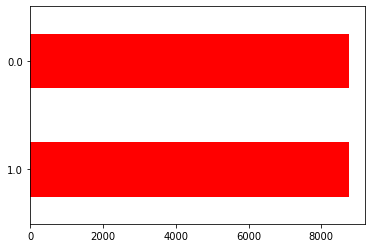

In [7]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

# Dense model

In [8]:
from DL import *

In [9]:
model = create_DNN_model(hl=1, hu=32, ent_dim = len(features.columns))

In [10]:
%%time
h = model.fit(features, target, epochs=50, validation_split=0.2,
          shuffle=False, verbose = False, class_weight = cw(target))


Wall time: 1min 14s


In [11]:
model.evaluate(features, target)

548/548 [==============================] - 3s 6ms/step - loss: 0.4780 - accuracy: 0.7652


[0.4780009388923645, 0.7651796340942383]

In [12]:
model.evaluate(features_test, target_test)

102/102 [==============================] - 0s 4ms/step - loss: 0.5081 - accuracy: 0.7457


[0.5080597400665283, 0.745673656463623]

In [13]:
model.predict(features)

548/548 [==============================] - 2s 3ms/step


array([[0.91335356],
       [0.6640512 ],
       [0.72798574],
       ...,
       [0.3132361 ],
       [0.15371315],
       [0.40042064]], dtype=float32)

In [14]:
df = pd.DataFrame(data = model.predict(features), columns=['predict_proba'])
df['predict'] = np.where(df['predict_proba']>0.5, 1, 0)
df

548/548 [==============================] - 2s 4ms/step


,predict_proba,predict
0,0.913354,1
1,0.664051,1
2,0.727986,1
3,0.869460,1
4,0.713253,1
...,...,...
17502,0.861696,1
17503,0.845867,1
17504,0.313236,0
17505,0.153713,0


In [15]:
df['predict'].value_counts()

0    9427
1    8080
Name: predict, dtype: int64

In [16]:
res = pd.DataFrame(h.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,1.679652,0.691896,0.666904,0.699886
1,0.566416,0.733667,0.650433,0.704455
2,0.552681,0.736451,0.602728,0.707596
3,0.534544,0.742164,0.567028,0.723872
4,0.521866,0.745377,0.548577,0.729012


In [17]:
px.line(res[['accuracy', 'val_accuracy']])

## Backtesting

In [25]:
def backtest(features, target, model):
    df = pd.DataFrame(data = model.predict(features), columns=['predict_proba'], index=features.index)
    df['predict'] = np.where(df['predict_proba']>0.5, 1, 0)
    df['return'] = features['ret_1_0']
    
    df['strategy'] = df['return'] * df['predict']
    df['strategy_c'] = (df['strategy'] + 1).cumprod()
    df['market'] = (df['return'] + 1).cumprod()
    fig = px.line(df[['market', 'strategy_c']])
    fig.show()


backtest(features, target, model)

548/548 [==============================] - 2s 3ms/step


In [26]:
backtest(features_test, target_test, model)

102/102 [==============================] - 1s 4ms/step
